# Sentiment Analysis IMDb Reviews

# Content <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#initiation)
* [3. Data Preparation](#data_prep)
    * [3.1 Load Data](#data_load)
    * [3.2 Missing Values & Duplicate](#missing)
* [4. Exploratory Data Analysis](#eda)
    * [4.1 Total Movies & Reviews](#totalmr)
    * [4.2 Distribution of Reviews](#distribution)
    * [4.3 Data-Imbalance Check](#imbalance)
    * [4.4 EDA Conclusions](#coclusions_eda)
* [5. Evaluation Procedure](#procedure)
* [6. Normalization](#normalization)
* [7. Train-Test Split](#split)
* [8. Modeling](#modeling)
    * [8.1 Model 0 - Constant](#dummy)
    * [8.2 Model 1 - NLTK, TF-IDF dan LR](#nltklr)
    * [8.3 Model 2 - spaCy, TF-IDF dan LR](#spacy_lr)
    * [8.4 Model 3 - spaCy, TF-IDF dan LGMClassifier](#spacy_lgbm)
* [9. My Reviews](#myreviews)
    * [9.1 Model 1](#model1)
    * [9.2 Model 2](#model2)
    * [9.3 Model 3](#model3)
* [Coclusions](#end)

## Introduction <a id='intro'></a>

The fil store wants to improve their services. They want to automatically detecting negative film reviews.

**Task** - Predict the probabilities of the reviews. The model, aims to achieve a minimum F1 score of 0.85.

**Data Description:**

There is a bunch of the columns, but the reviews stored in `review` column and the positive class store in `pos` column.

## Initiation <a id='initiation'></a>

In [1]:
# Math Library
import math

# Preparation Library
import numpy as np
import pandas as pd

# Regular Expression Library
import re

# Visualization Library
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Sci-Kit Lear Library
import sklearn.metrics as metrics

# Progress Library
from tqdm.auto import tqdm

In [2]:
# Configuration Settings
%matplotlib inline
%config InlineBackend.figure_format = 'png'

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# Progress Bar Initiate
tqdm.pandas()

## Data Preparation <a id='data_prep'></a>

### Data Loading <a id='data_load'></a>

In [4]:
# Data Loading
data = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

# Show Sample
data.head(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


There is a bunch of information within the datasets. When performing sentiment analysis, the crucial feature is the text, while the target should represent the sentiment. Other details, although not essential for the model, will be considered during the exploratory phase. The primary information resides in the `review` column, which will serve as the key feature. The target for the model is provided in string format within the `sp` column and in binary form within the `pos` column. The `pos` column will be selected for model training due to its inherent numerical representation. Finally, the `ds_part` column will be utilized to partition the dataset into training and testing sets.

### Missing Value & Duplicate <a id='missing'></a>

In [5]:
# Remove Duplicate
data = data.drop_duplicates()

In [6]:
# Remove Missing Values
data = data.dropna()

## EDA

### Total Movies & Reviews <a id='totalmr'></a>

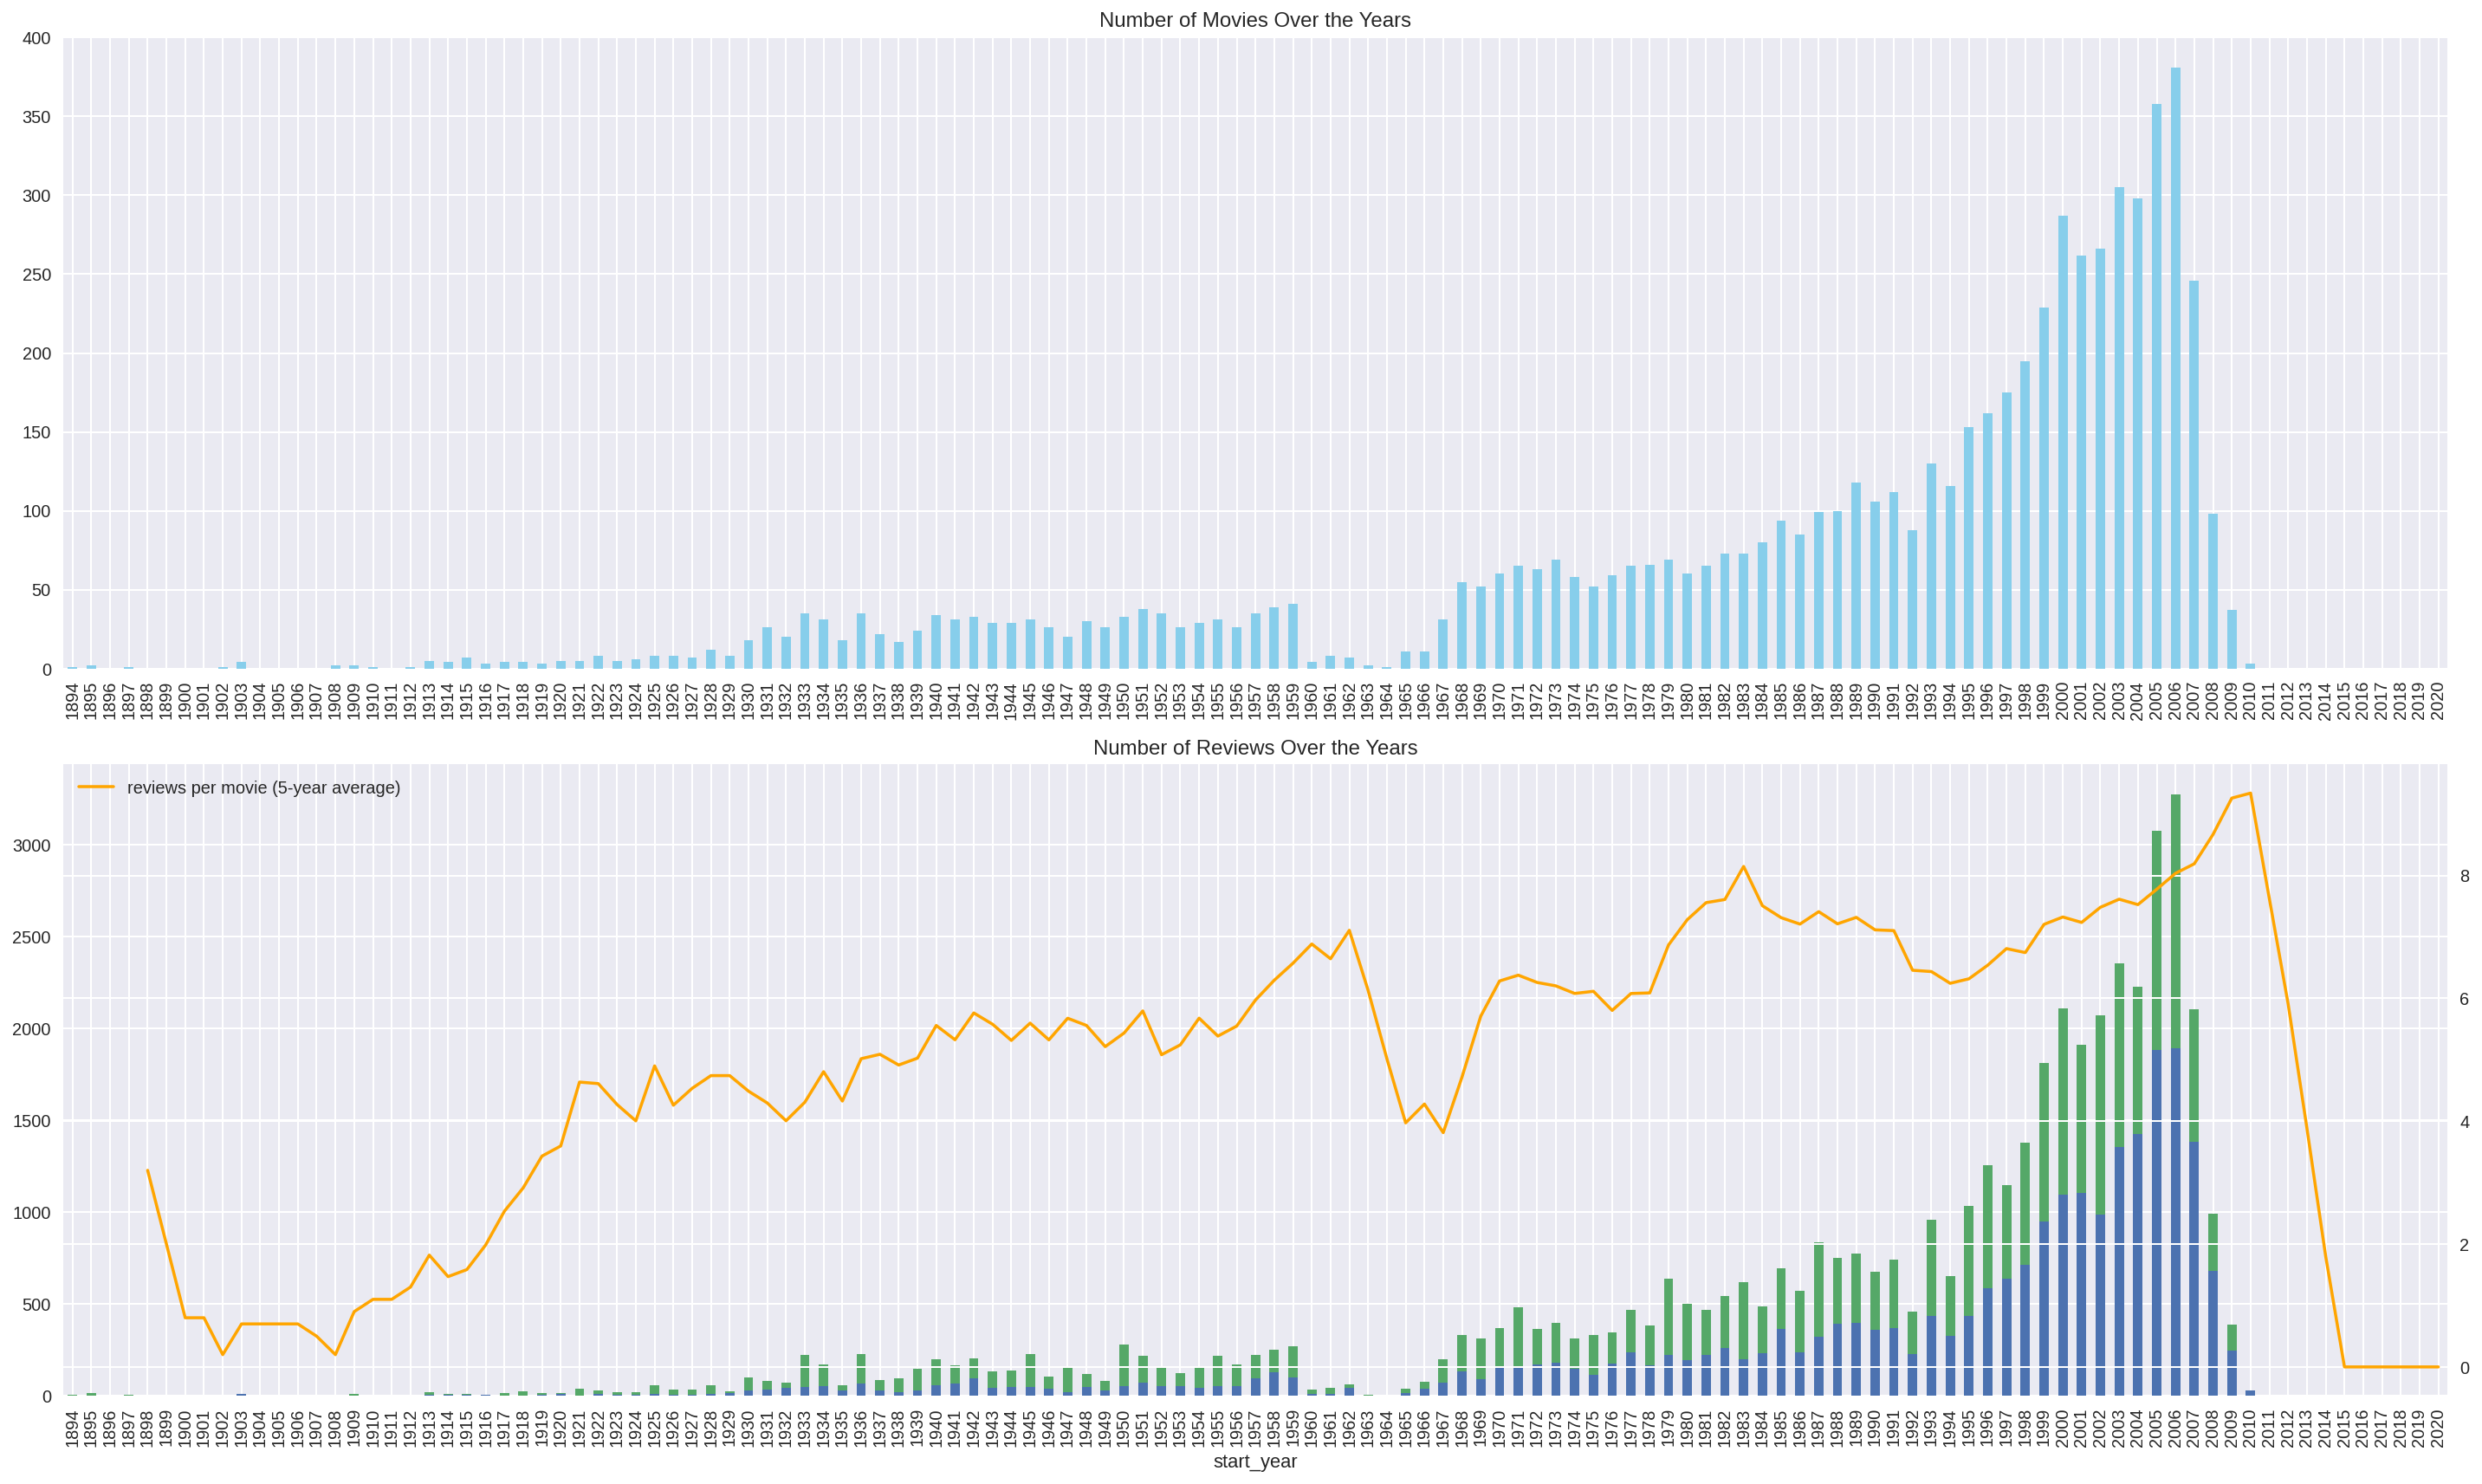

In [7]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Number of Movies Over the Years
ax1 = axs[0]
movie_counts = data[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
movie_counts = movie_counts.reindex(index=np.arange(movie_counts.index.min(), max(movie_counts.index.max(), 2021))).fillna(0)
movie_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Number of Movies Over the Years')

# Plot 2: Number of Reviews (Positive and Negative) Over the Years
ax2 = axs[1]
reviews_by_year = data.groupby(['start_year', 'pos'])['pos'].count().unstack()
reviews_by_year = reviews_by_year.reindex(index=np.arange(reviews_by_year.index.min(), max(reviews_by_year.index.max(), 2021))).fillna(0)
reviews_by_year.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax2)

# Calculate and plot the average reviews per movie over a 5-year rolling window
movie_counts_total = data['start_year'].value_counts().sort_index().reindex(index=np.arange(movie_counts.index.min(), max(movie_counts.index.max(), 2021))).fillna(0)
reviews_per_movie = (movie_counts_total / movie_counts).fillna(0)
ax2t = ax2.twinx()
reviews_per_movie.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (5-year average)', ax=ax2t)

# Configure legends
lines, labels = ax2t.get_legend_handles_labels()
ax2.legend(lines, labels, loc='upper left')
ax2.set_title('Number of Reviews Over the Years')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

There has been significant rise in the number of movies per year, peaking around 2006 and then decline significantly. That's mean the review will be increasing over the years to and balance of the negative and positive review should be considered. But there are balanced distribution of negative and positive reviews.

### Distribution of Reviews <a id='distribution'></a>

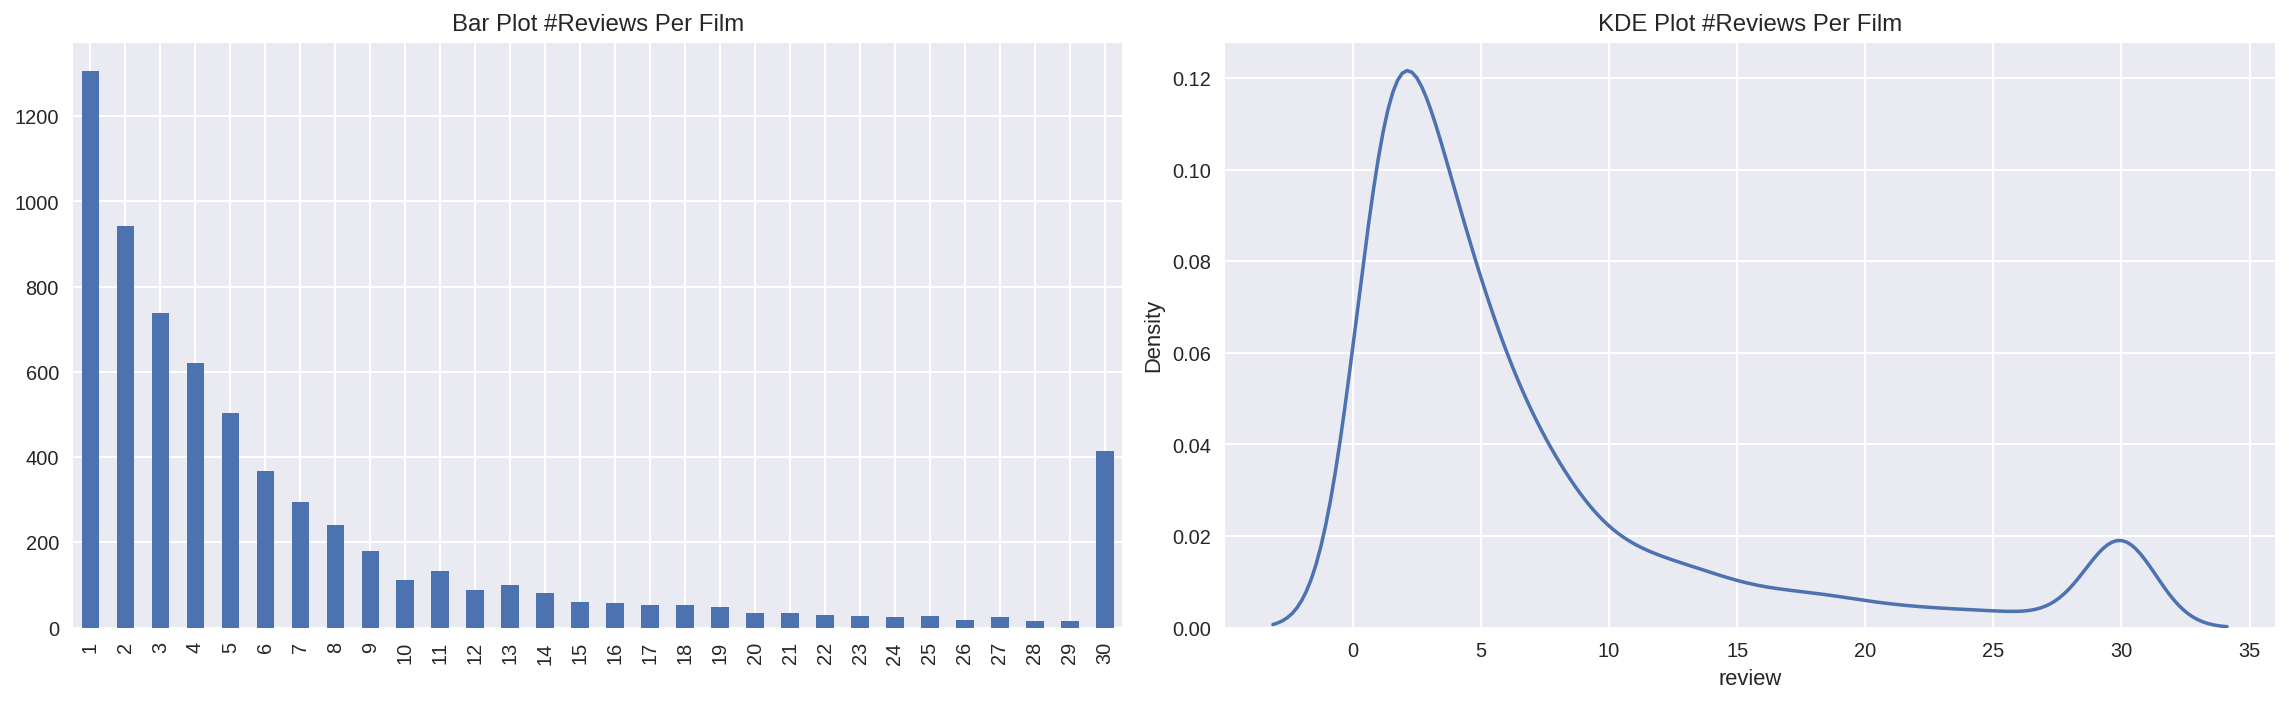

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Bar Plot of the Number of Reviews Per Film
ax = axs[0]
dft = data.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot #Reviews Per Film')

# Plot 2: Kernel Density Estimate (KDE) Plot of the Number of Reviews Per Film

ax = axs[1]
dft = data.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot #Reviews Per Film')

fig.tight_layout()

**Bar Plot of the Number of Reviews Per Film (Left Plot):**

The majority of movies have only a few reviews, with one review being the most common.

**Kernel Density Estimate (KDE) Plot of the Number of Reviews Per Film (Right Plot):**

The KDE plot highlights that the most densely populated range of reviews per film is within 1 to 5 reviews, indicating a concentration of movies with a low number of reviews. For some movies with only limited review couldn't be representation of each film, but the model still will detect the sentiment of the review.

### Class-Imbalance Check <a id='imbalance'></a>

**All Datasets**

In [9]:
# Check the target-imbalance
data['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

**Distribution of Train-Test Datasets**

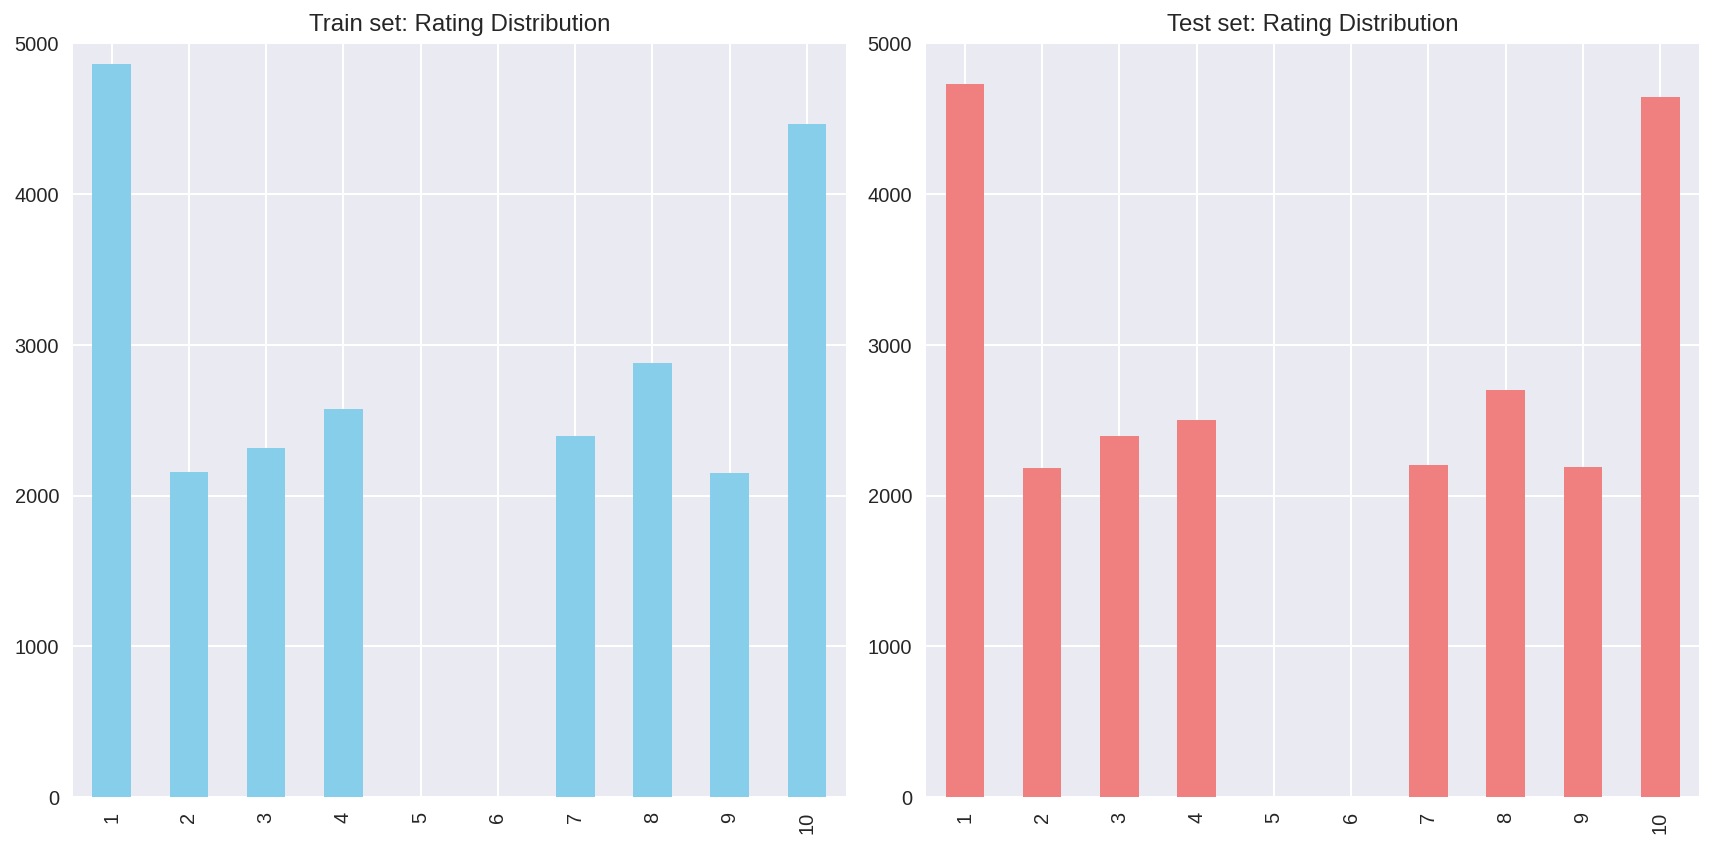

In [10]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Bar Plot for the Train Set Ratings Distribution
ax1 = axs[0]
dft_train = data.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft_train = dft_train.reindex(index=np.arange(min(dft_train.index.min(), 1), max(dft_train.index.max(), 11))).fillna(0)
dft_train.plot.bar(ax=ax1, color='skyblue')  # Specify color
ax1.set_ylim([0, 5000])
ax1.set_title('Train set: Rating Distribution')

# Plot 2: Bar Plot for the Test Set Ratings Distribution
ax2 = axs[1]
dft_test = data.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft_test = dft_test.reindex(index=np.arange(min(dft_test.index.min(), 1), max(dft_test.index.max(), 11))).fillna(0)
dft_test.plot.bar(ax=ax2, color='lightcoral')  # Specify color
ax2.set_ylim([0, 5000])
ax2.set_title('Test set: Rating Distribution')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

In this step, the imbalance between negative (0) and positive (1) reviews in the `pos` column and the distribution of the ratings of each dataset is checked. The dataset is nearly balanced between negative and positive reviews, which is beneficial for training a sentiment analysis model. 

**Class-Imbalance of Target in each Datasets**

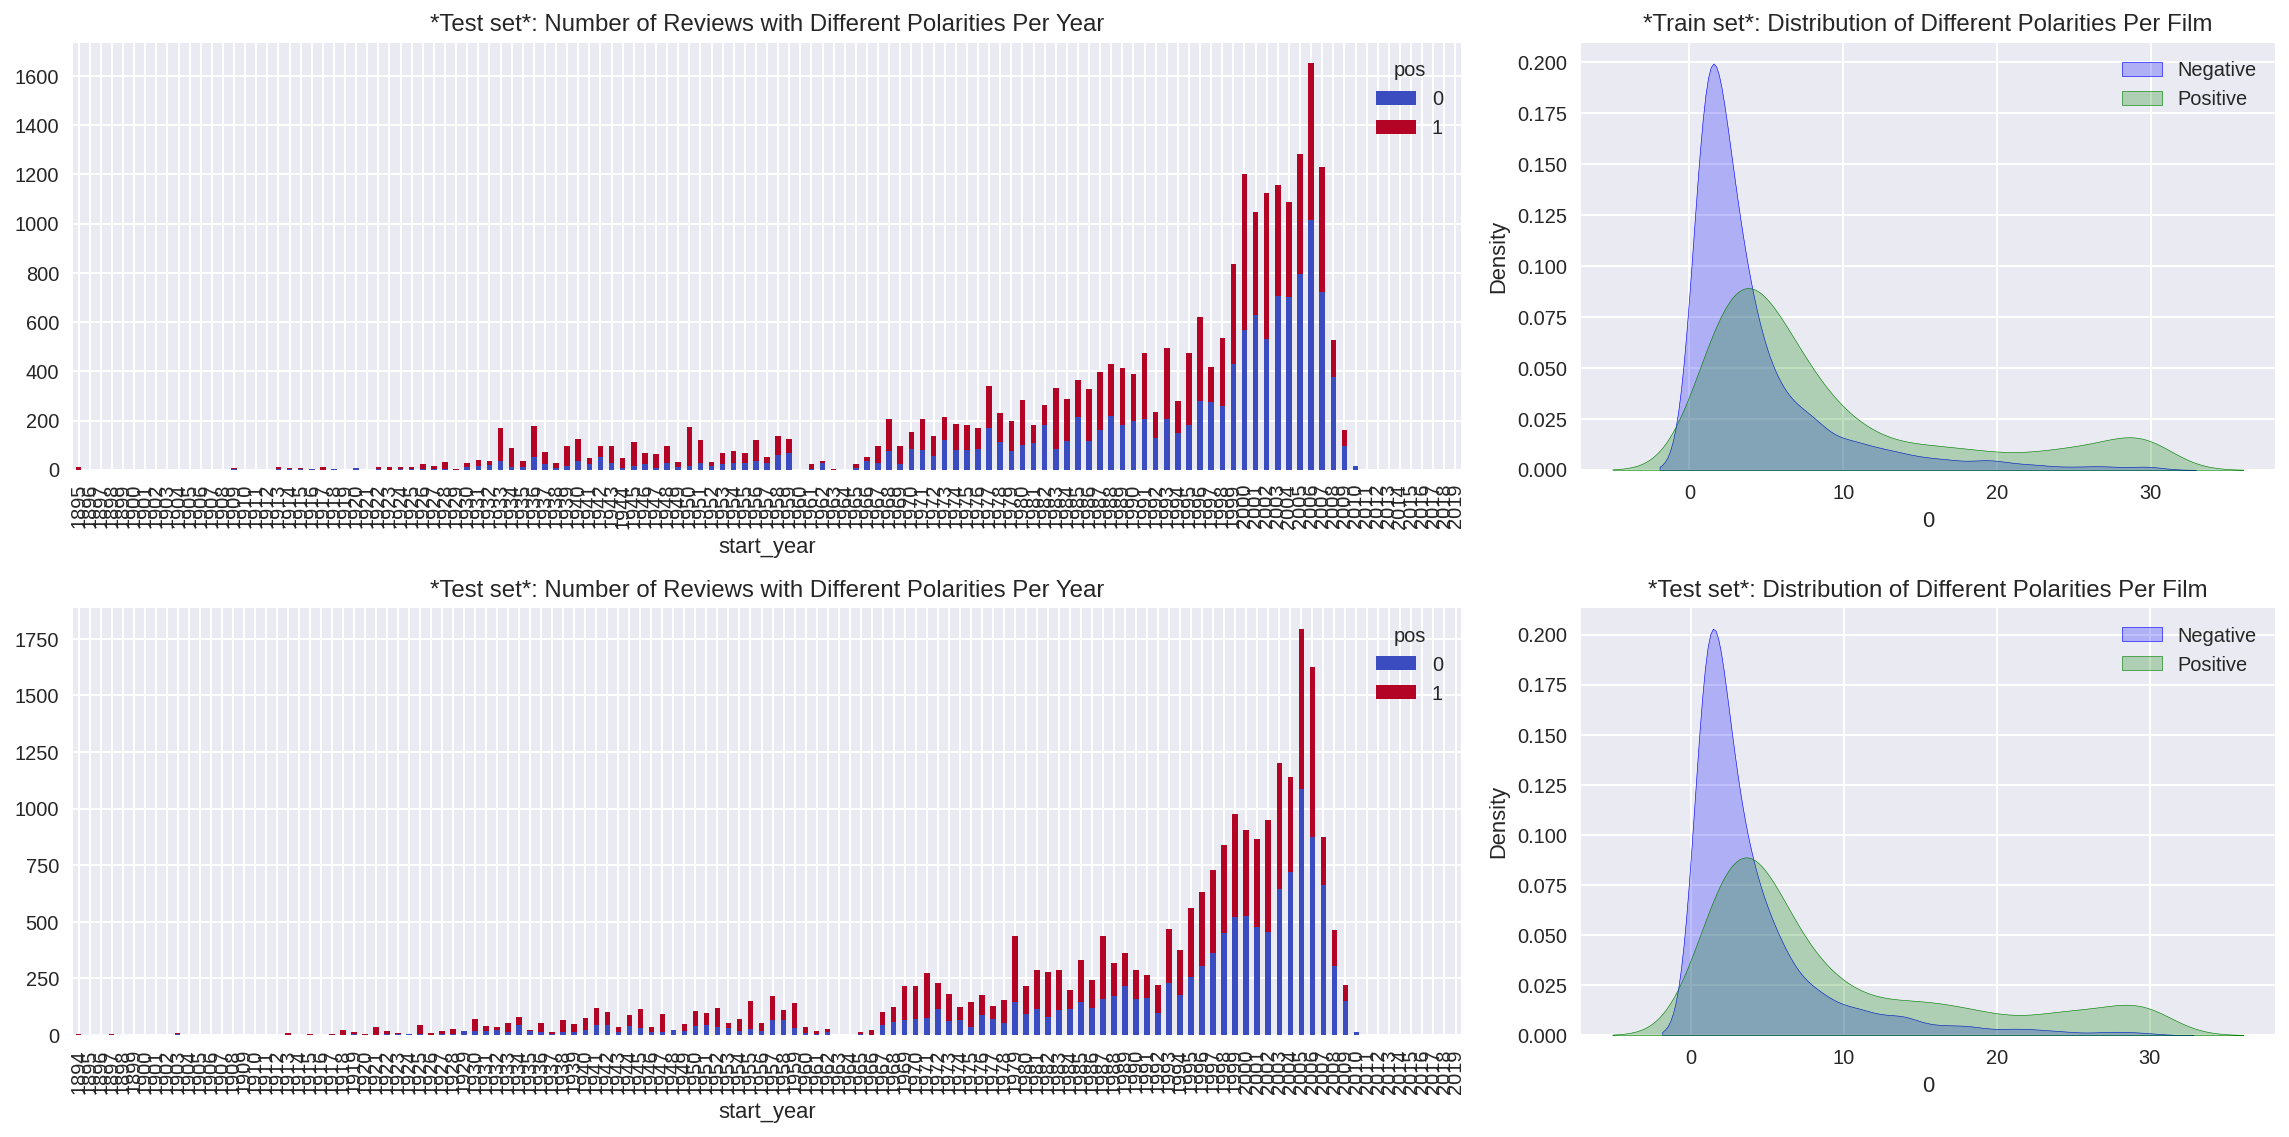

In [11]:
# Create subplots with customized styles
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Plot 1: Bar Plot for Test Set Ratings Distribution Per Year
ax1 = axs[0][0]
dft_train_year = data.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft_train_year.index = dft_train_year.index.astype('int')
dft_train_year = dft_train_year.reindex(index=np.arange(dft_train_year.index.min(), max(dft_train_year.index.max(), 2020))).fillna(0)
dft_train_year.plot(kind='bar', stacked=True, ax=ax1, cmap='coolwarm')  # Specify colormap
ax1.set_title('*Test set*: Number of Reviews with Different Polarities Per Year')

# Plot 2: KDE Plot for Train Set Ratings Distribution Per Film
ax2 = axs[0][1]
dft_train_film = data.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft_train_film[0], color='blue', label='Negative', ax=ax2, fill=True)
sns.kdeplot(dft_train_film[1], color='green', label='Positive', ax=ax2, fill=True)
ax2.legend()
ax2.set_title('*Train set*: Distribution of Different Polarities Per Film')

# Plot 3: Bar Plot for Test Set Ratings Distribution Per Year (Duplicate Title Corrected)
ax3 = axs[1][0]
dft_test_year = data.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft_test_year.index = dft_test_year.index.astype('int')
dft_test_year = dft_test_year.reindex(index=np.arange(dft_test_year.index.min(), max(dft_test_year.index.max(), 2020))).fillna(0)
dft_test_year.plot(kind='bar', stacked=True, ax=ax3, cmap='coolwarm')  # Specify colormap
ax3.set_title('*Test set*: Number of Reviews with Different Polarities Per Year')

# Plot 4: KDE Plot for Test Set Ratings Distribution Per Film (Duplicate Title Corrected)
ax4 = axs[1][1]
dft_test_film = data.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft_test_film[0], color='blue', label='Negative', ax=ax4, fill=True)
sns.kdeplot(dft_test_film[1], color='green', label='Positive', ax=ax4, fill=True)
ax4.legend()
ax4.set_title('*Test set*: Distribution of Different Polarities Per Film')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

### EDA Conclusions <a id='conclusions_eda'></a>

The exploratory data analysis (EDA) reveals a balanced distribution between negative and positive sentiments in both the target variable and the train/test datasets. The number of reviews with different polarities per year suggests an overall upward trend, indicating a growing volume of reviews over time.

The balanced distribution of negative and positive sentiments in the target variable is crucial for model training. It ensures that the machine learning model has sufficient examples of both classes, enhancing its ability to learn and generalize well.

The balance observed in both train and test datasets is essential for model evaluation. A balanced test set allows for a fair assessment of the model's performance on both positive and negative sentiments. Datasets is ready for the next step.

## Evaluation Procedure <a id='procedure'></a>

In [12]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # Set markers for some threshold crossings
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score') 

        # ROC Curve
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # Set markers for some threshold crossings
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.legend(loc='lower center')        
        ax.set_title('ROC Curve')
        
        # Precision-Recall Curve
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, APS={aps:.2f}')
        # Set markers for some threshold crossings
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1 Score'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1 Score', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

This **evaluate_model** function assesses how well a binary classification model performs. Bounded as function to make it easy to call for each model.

Here's a breakdown:

**Inputs:**

model: The binary classification model you want to evaluate.

train_features, train_target: Features and labels of the training set.

test_features, test_target: Features and labels of the testing set.

**Actions:**

1. Prediction:

The function uses the model to predict labels and probabilities for both the training and testing sets.

2. Evaluation Metrics:

It calculates and shows three important metrics: F1 Score, ROC Curve, and Precision-Recall Curve.

The curves illustrate how well the model distinguishes between positive and negative cases at different confidence levels.

3. Summary Statistics:

The function computes Accuracy, F1 Score, APS (Average Precision Score), and ROC AUC.

It prints a table summarizing these metrics for both the training and testing sets.

4. Visualization:

Creates a 3-panel plot displaying F1 Score, ROC Curve, and Precision-Recall Curve for both training and testing sets.

Markers on the curves highlight specific confidence level crossings.

5. Output:

A summary table of key metrics and visualizations to help you understand how well the model is performing on both training and testing data.

In sum, this function is a tool to get insights into the strengths and weaknesses of your binary classification model.

## Normalization <a id='normalization'></a>

In [13]:
# Create function to clean the text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [14]:
# Apply to the datasets
data['review_norm'] = data['review'].apply(clean_text)

# Check the samples
data[['review', 'review_norm']].head()

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,im totally agree with garryjohal from singapor...


The input should be clean from punctuation, non-ascii character, numbers, etc. In order to fix that, in this step we created `clean_text` function and apply it to the `review` column. By converting text to lowercase and removing non-essential elements, the data likely more consistent and normalized. This preprocessing step is essential for improving the text quality before feeding it into a sentiment analysis model.

## Train-Test Split <a id='split'></a>

In [15]:
# Split the datasets
data_train = data.query('ds_part == "train"').copy()
data_test = data.query('ds_part == "test"').copy()

train_target = data_train['pos']
test_target = data_test['pos']

print(data_train.shape)
print(data_test.shape)

(23796, 18)
(23533, 18)


## Modeling <a id='modeling'></a>

### Model 0 - Constant <a id='dummy'></a>

In [16]:
# Import the library for dummy classifier
from sklearn.dummy import DummyClassifier

In [17]:
# Create a constant model predicting all 0s
model_0 = DummyClassifier(strategy='constant', constant=0)

# Train the model on the training data
model_0.fit(data_train['review_norm'], data_train['pos'])

DummyClassifier(constant=0, strategy='constant')

          train  test
Accuracy    0.5   0.5
F1 Score    0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


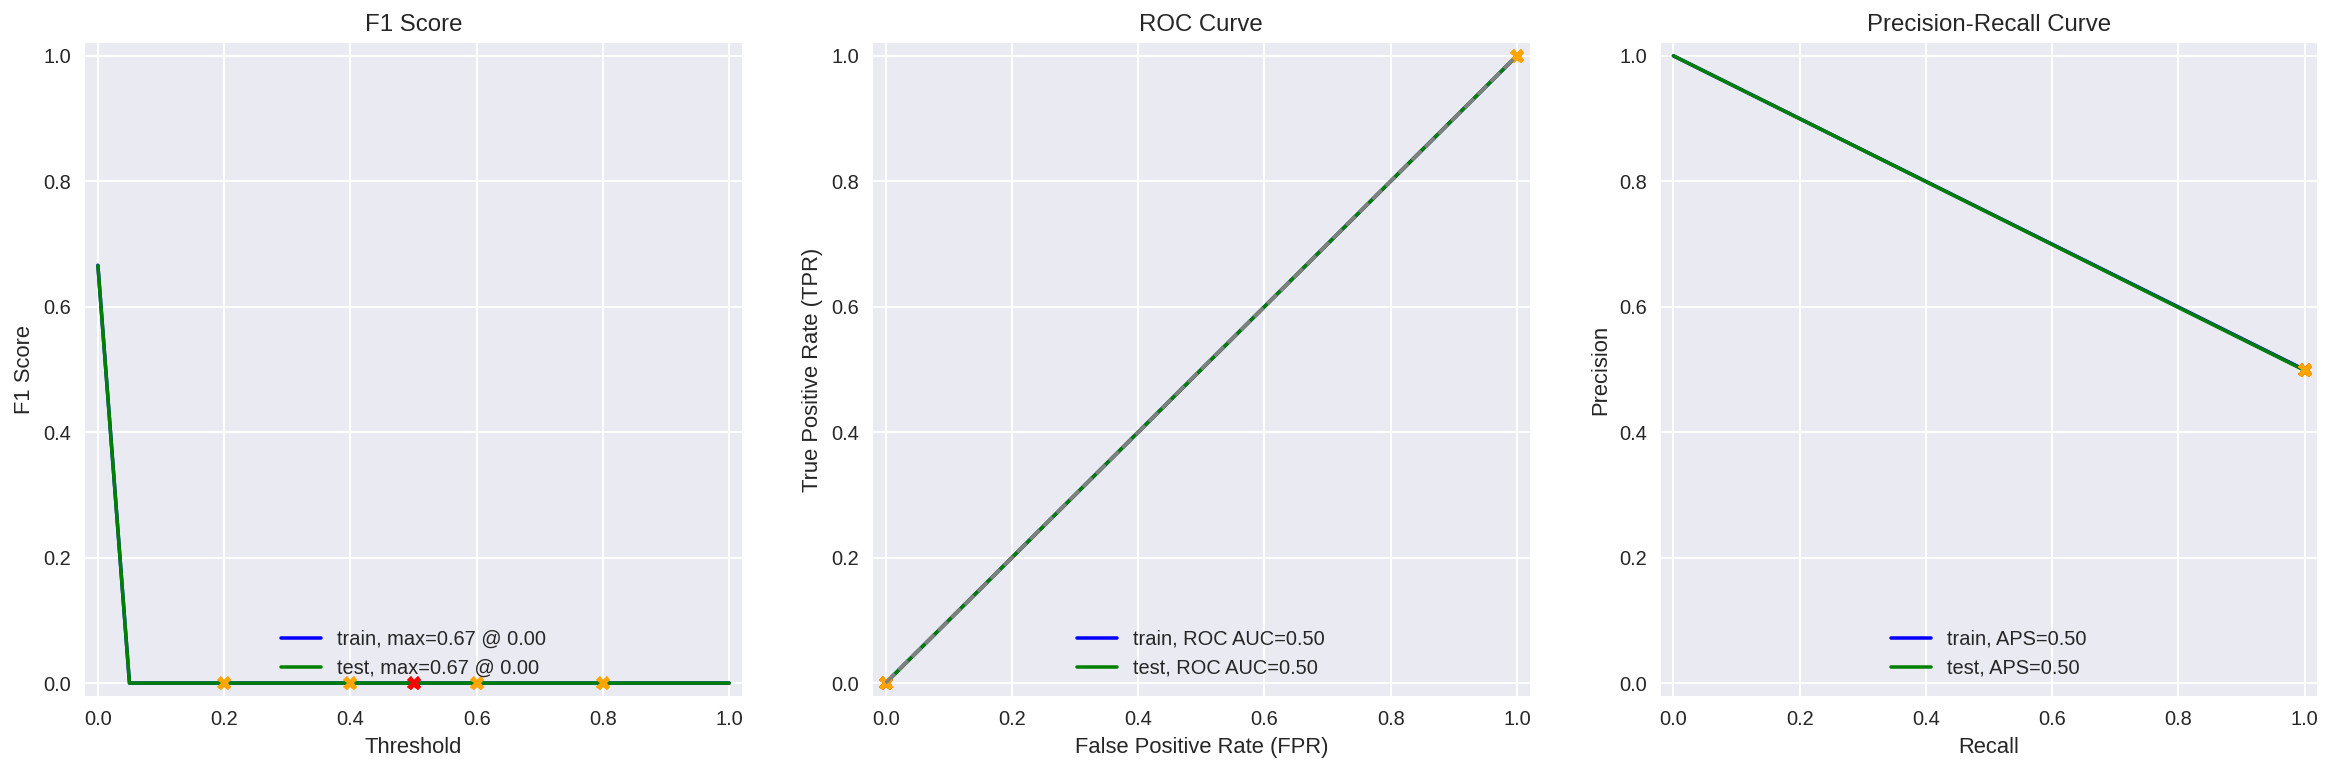

In [18]:
# Evaluate the model using the evaluate_model function
evaluate_model(model_0,
               data_train['review_norm'],
               data_train['pos'],
               data_test['review_norm'],
               data_test['pos']
              )

The dummy model predicting all 0 (negative sentiment) for every input. This type of model serves as a basic benchmark for comparison and helps evaluate. For all of the metric show 0.5 score which mean the data is balance because in the constant output the probabilty is 50-50.

### Model 1 - NLTK, TF-IDF dan LR <a id='nltklr'></a>

In [19]:
# Import NLTK
import nltk
from nltk.corpus import stopwords

# Import SKLearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [20]:
# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_train['review_norm'], data_train['pos'], test_size=0.2, random_state=42
)

In [22]:
# Create a pipeline with TF-IDF and Logistic Regression
model_1 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords.words('english'))),
    ('classifier', LogisticRegression(random_state=42))
])

# Train the model
model_1.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classifier', LogisticRegression(random_state=42))])

          train  test
Accuracy   0.94  0.89
F1 Score   0.94  0.89
APS        0.98  0.96
ROC AUC    0.98  0.95


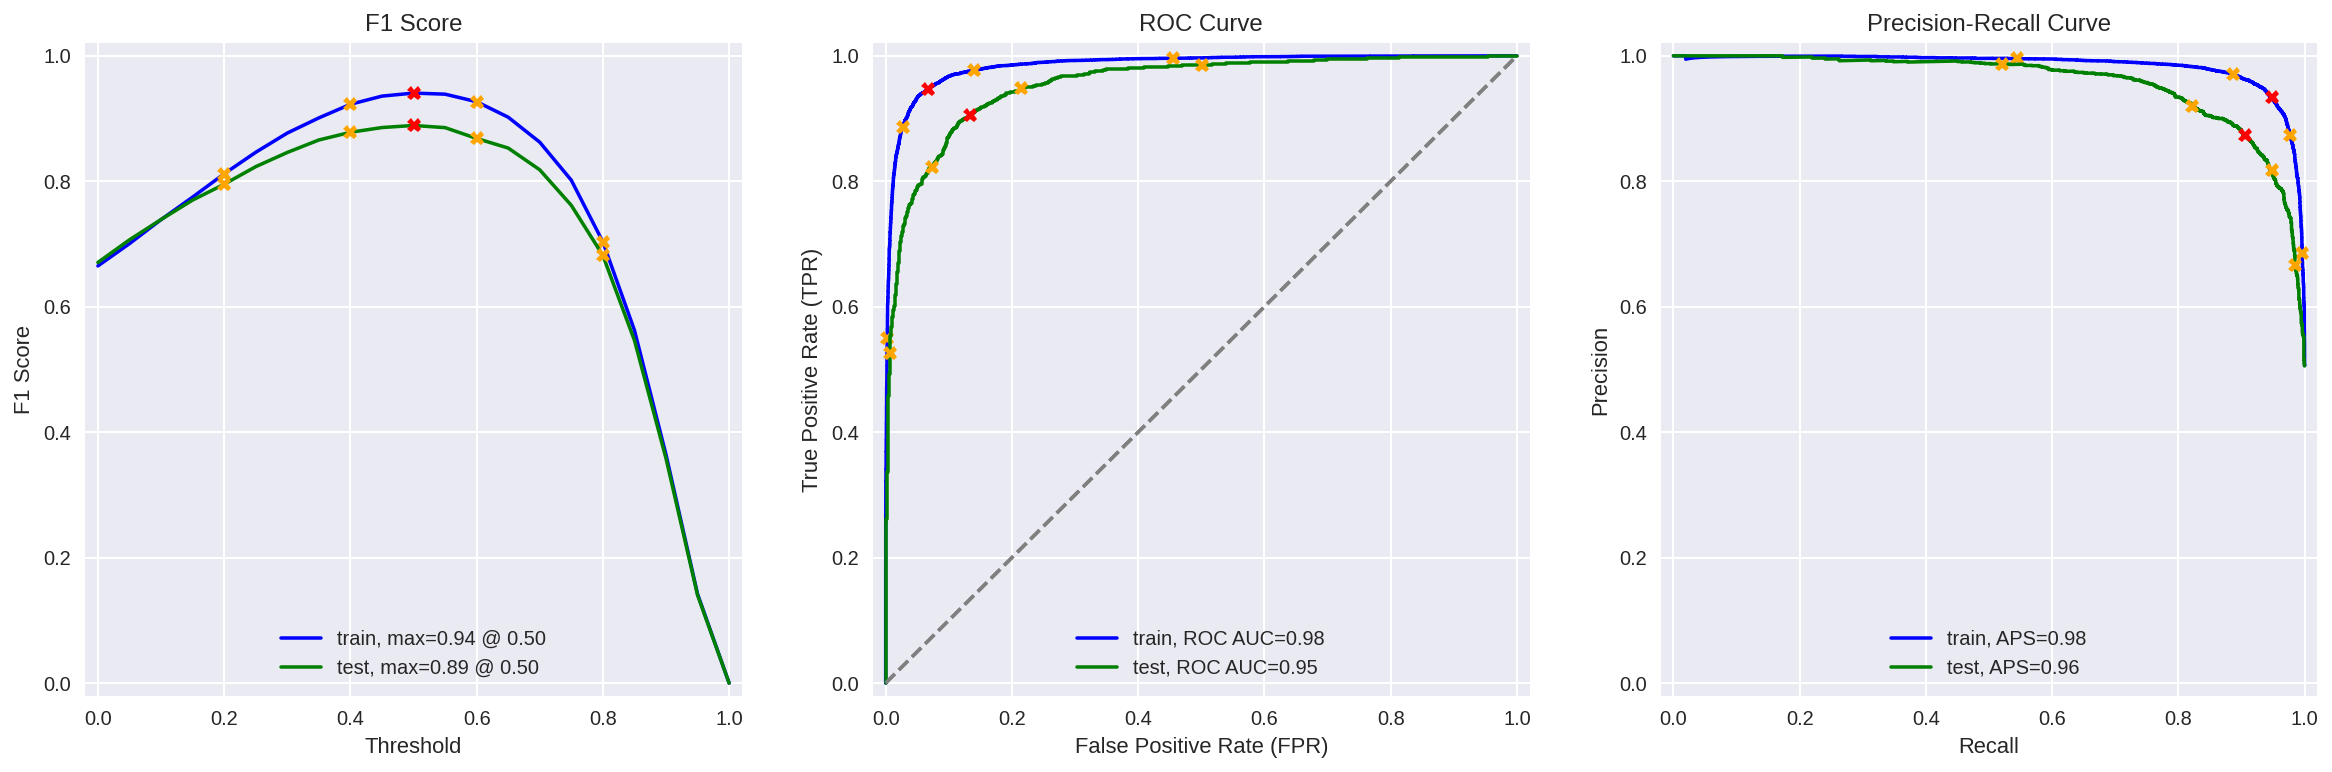

In [23]:
# Evaluate the model using the evaluate_model function
evaluate_model(model_1, X_train, y_train, X_test, y_test)

The second model (model_1) is a Logistic Regression model. It is a text classification model using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization combined with Logistic Regression. This model leverages the NLTK library to remove English stopwords during TF-IDF vectorization.

**Model Performance Summary:**

`model_1` outperforms the baseline, showcasing the power of TF-IDF with Logistic Regression for sentiment analysis. But there is a little bit issue about overfitting on the model since there is some gap between model performance on th train and the test data.

### Model 2 - spaCy, TF-IDF dan LR <a id='spacy_lr'></a>

In [24]:
# Import Spacy Library
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
# Create function for tokenize text
def spacy_tokenizer(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [26]:
# Create a pipeline with spaCy, TF-IDF, and Logistic Regression
model_2 = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=spacy_tokenizer)),
    ('classifier', LogisticRegression(random_state=42))
])

# Train the model
model_2.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7fe2fb8f8af0>)),
                ('classifier', LogisticRegression(random_state=42))])

          train  test
Accuracy   0.63  0.64
F1 Score   0.63  0.64
APS        0.67  0.68
ROC AUC    0.68  0.69


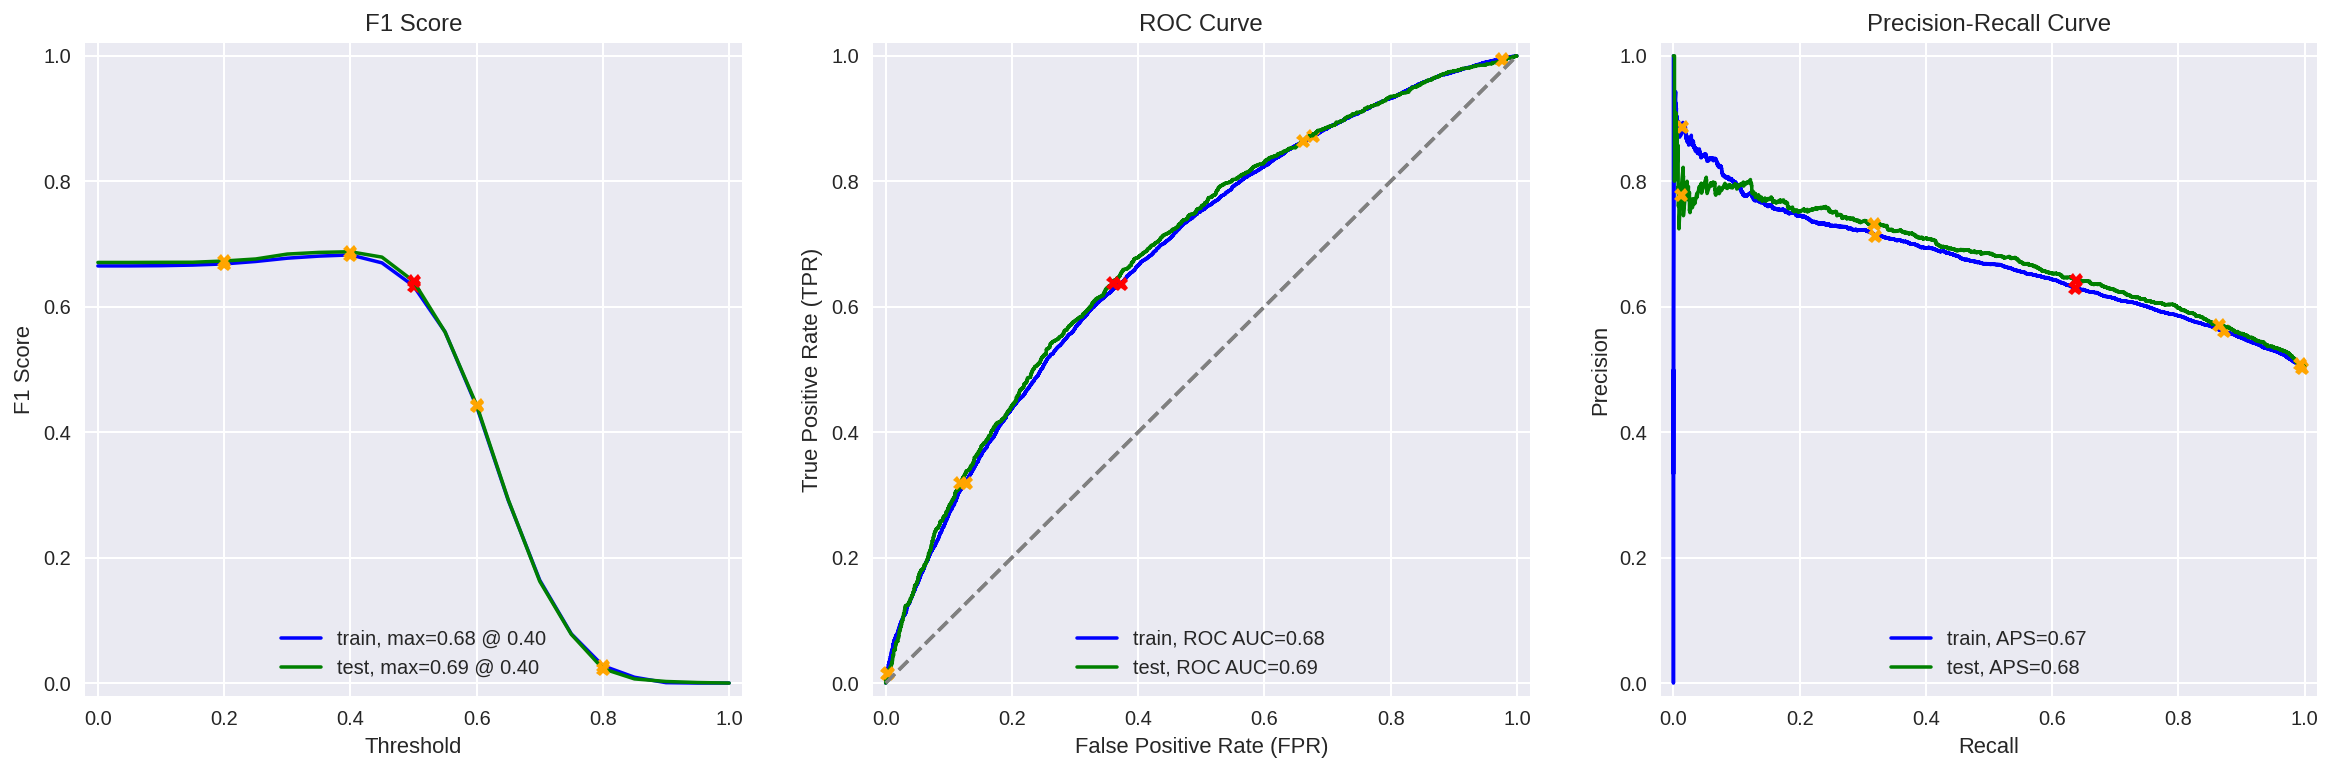

In [27]:
# Evaluate the model using the evaluate_model function
evaluate_model(model_2, X_train, y_train, X_test, y_test)

The third model (model_2) incorporates spaCy for tokenization along with TF-IDF vectorization and Logistic Regression in a pipeline. It uses the English language model provided by spaCy (en_core_web_sm) and focuses on lemmatization while excluding stop words during tokenization.

**Model Performance Summary:**

`model_2` shows a stable performance with moderate accuracy, F1 scores, APS, and ROC AUC on both training and testing datasets. The model performance is outperformed constant model but need to increasing their performance.

### Model 3 - spaCy, TF-IDF dan LGBMClassifier <a id='spacy_lgbm'></a>

In [28]:
# Import LGBM Library
from lightgbm import LGBMClassifier

In [29]:
# Create a pipeline with spaCy, TF-IDF, and LGBMClassifier
model_3 = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=spacy_tokenizer)),
    ('classifier', LGBMClassifier(random_state=1234))
])

In [30]:
# Train the model
model_3.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7fe2fb8f8af0>)),
                ('classifier', LGBMClassifier(random_state=1234))])

          train  test
Accuracy   0.77  0.63
F1 Score   0.77  0.63
APS        0.86  0.67
ROC AUC    0.86  0.68


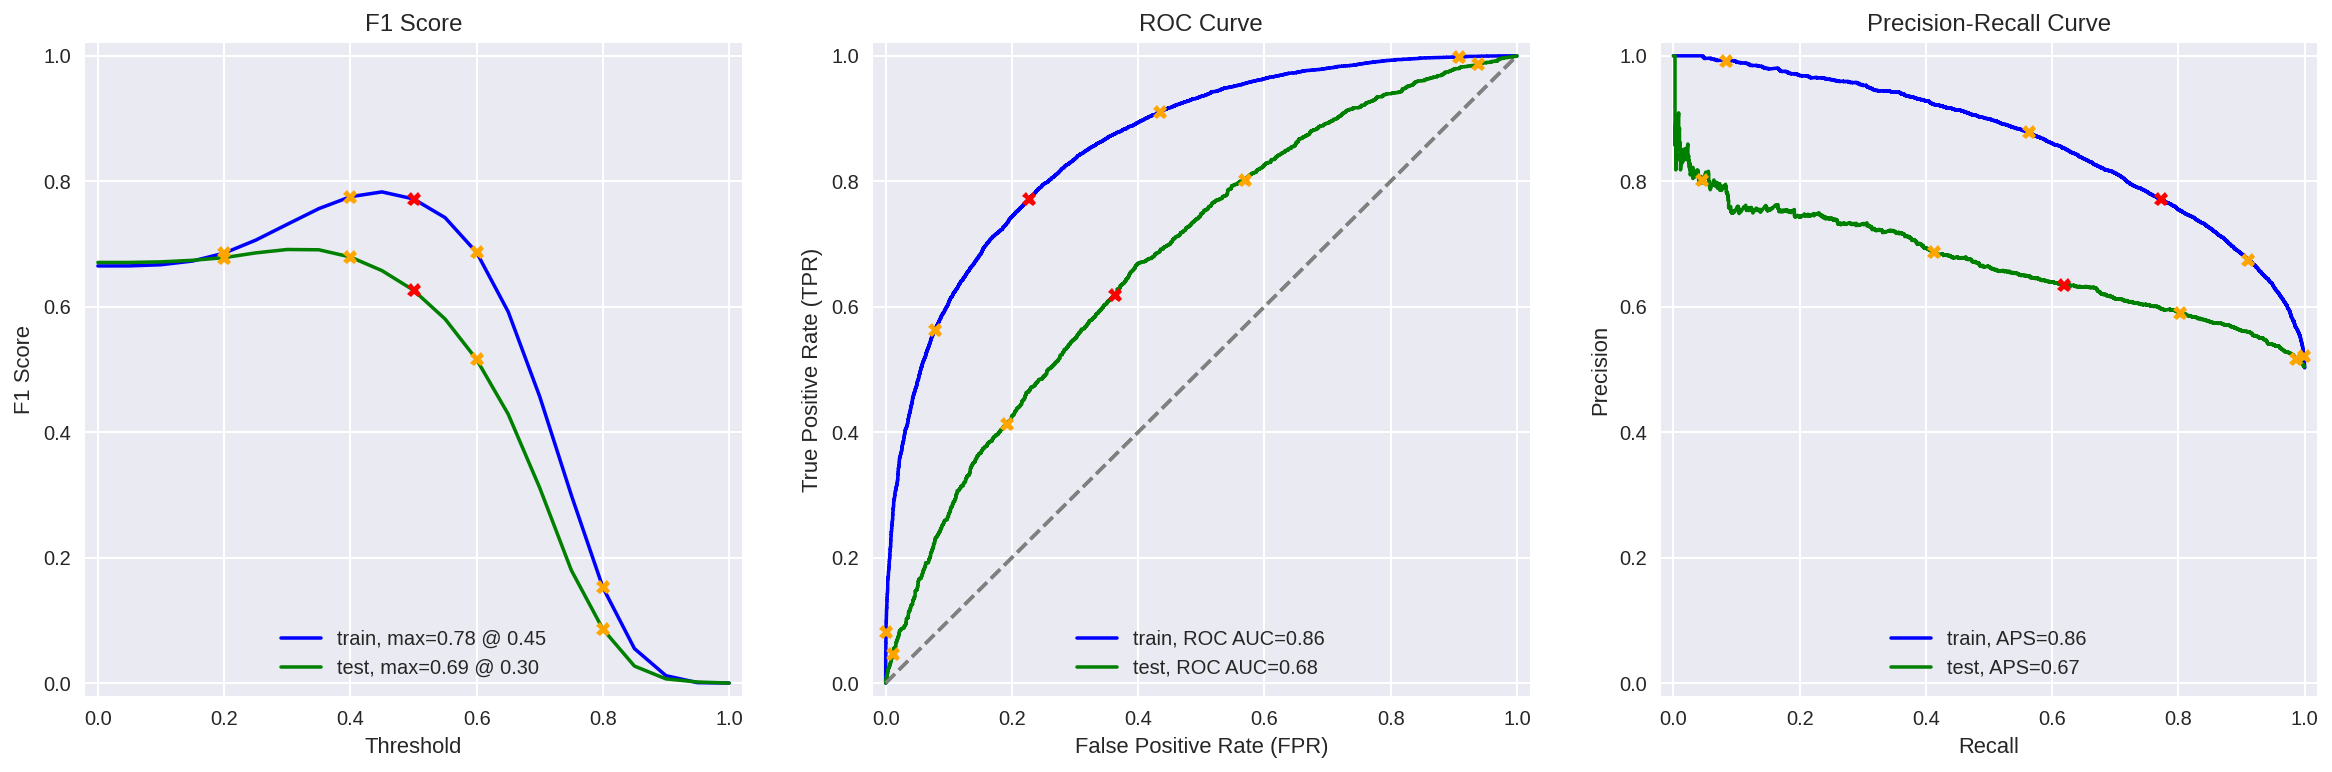

In [31]:
# Evaluate the model using the evaluate_model function
evaluate_model(model_3, X_train, y_train, X_test, y_test)

The fourth model (`model_3`) employs spaCy for tokenization, TF-IDF vectorization, and the LightGBM classifier in a pipeline.

**Model Performance Summary:**

Accuracy: The model demonstrates a high accuracy of 77% on the training set but a lower accuracy of 63% on the testing set.

F1 Score: F1 scores are high, with 77% on the training set and 63% on the testing set, showcasing a balance between precision and recall.

APS (Average Precision Score): APS values are high, with 0.86 for the training set and 0.67 for the testing set, indicating strong precision and recall performance.

ROC AUC: ROC AUC is high, with 0.86 for the training set and 0.68 for the testing set, reflecting overfitting.

`model_3` exhibits high performance on the training set, with strong accuracy, F1 scores, APS, and ROC AUC. However, there is a drop in performance on the testing set, suggesting potential overfitting. This model, powered by LightGBM, showcases powerful predictive capabilities but may require further tuning for generalization on unseen data.

## Conclusions <a id='conclusions'></a>

The sentiment analysis IMDb reviews has successfully demonstrated the effectiveness of natural language processing (NLP) techniques in capturing the sentiments expressed in user reviews. By employing advanced machine learning models, we have been able to predict the probabilities of the reviews into positive nuances with a higher degree of 0.82 accuracy. 

Thus, the data is prepared and trained by various models. The best model in terms of the quality of the F1 metric was LogisticRegression showing on the test sample the F1 value equal to 0.89 on the test sample.